### Complex Networks
### Programming Assignment 2
### Jason Thomas
### s3907634

---

Please note, where it made sense to do so I moved code into functions in another file. See the appendix at the end of this document.

### Question 1

This question has a few parts so I'll address the parts under headings.

#### Q1.1 Plot of network

I found it convenient to run the script `generateChart.R` in Rstudio, and it creates an interactive plot. This is a screenshot from that.

![main rende](mainRender.png)

#### Q1.2 Obvious hubs

To see if there exist obvious hubs, you might like to see the edges ordered by degree.

This doesn't identify the hubs, since the question only asks "are there any obvious hubs". See the chart below.

In [1]:
# I wanted to use some igraph features
# so it's easier to use it for all tasks
library('igraph');


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




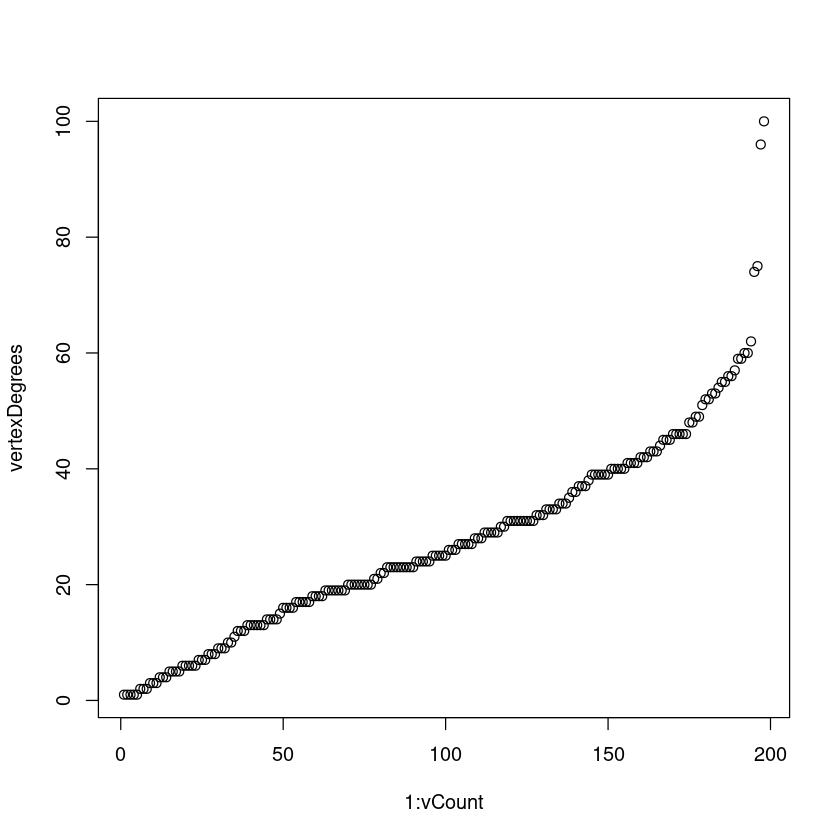

In [2]:
jazz <- as.matrix(read.table("jazz_edgelist.txt"));

# Duplicate edges was problematic for igraph, so we remove them.
uniqueJazz = unique(jazz);

jazzNet <- igraph::graph_from_edgelist(uniqueJazz,
                                       directed = FALSE);

vertexDegrees = sort(igraph::degree(jazzNet));
vCount = igraph::vcount(jazzNet);

plot(1:vCount, vertexDegrees);


The answer is yes there are 2, or perhaps 4, that appear to be outliers.

#### Q1.3 Max degree

In [3]:
jazzNet_maxDegree = max(igraph::degree(jazzNet));
jazzNet_maxDegree

[1] 100

### Question 2

The mean degree is $ \left<k\right> $ = 

In [4]:
jazzNet_meanDegree = mean(igraph::degree(jazzNet));
jazzNet_meanDegree

[1] 27.69697

We have seen that the threshold for the supercritical regime is:

$ \ln(\left<k\right>) = 1 $

Then this shows that the network is supercritical:

In [5]:
log(jazzNet_meanDegree) > 1

[1] TRUE

This makes sense because the network was generated from an edge list, and so the network should of course be connected, meaning $ \frac{N_G}{N} = 1 $.

### Question 3

Before we can generate random graphs, let's think about the properties of the jazz network.

It has 198 nodes so if every single edge was in the network, there would be $ \left( \begin{matrix} 198 \\ 2 \end{matrix} \right) $ edges. This breaks vanilla R. The number of possible edges is:

In [6]:
library('combinat');


Attaching package: ‘combinat’


The following object is masked from ‘package:utils’:

    combn




In [7]:
r = 2 # need two nodes to have an edge
possibleEdges = ncol(combn(vCount, r));
possibleEdges

[1] 19503

The total number of edges is:

In [8]:
actualEdges = igraph::gsize(jazzNet);
actualEdges

[1] 2742

So, the best chance to generate the jazz network using a random graph (ER model) would be with $ p $:

In [9]:
p = actualEdges/possibleEdges;
p

[1] 0.1405938

Let's now use this information to produce a lot of random graphs, and then record the important details about them.

For brevity, clustering coefficient will be written as transitivity, as it is called in `igraph`.

In [10]:
source('my_functions.R');
randomGraphData = getRandomGraphData(400, vCount, p);

In [11]:
randomGraph_mean_apl = mean(randomGraphData$apl);
randomGraph_mean_apl

[1] 1.876357

In [12]:
randomGraph_mean_maxDegree = mean(randomGraphData$maxDegree);
randomGraph_mean_maxDegree

[1] 41.69

In [13]:
randomGraph_mean_transitivity = mean(randomGraphData$transitivity);
randomGraph_mean_transitivity

[1] 0.1407316

The relevant measures for the jazz network are:

In [14]:
jazzNet_apl = igraph::average.path.length(jazzNet);
jazzNet_apl

[1] 2.235041

In [15]:
# This is computed in question 1.3
jazzNet_maxDegree

[1] 100

In [16]:
jazzNet_transitivity = igraph::transitivity(jazzNet);
jazzNet_transitivity

[1] 0.5202593

Below we can see the histogram of each each of the measures: `average path length`, `max degree` and `transitivity`. Each of these measures are applied to the family of random graphs. Each measure is shown with and without the relevant metric for the jazzNet.

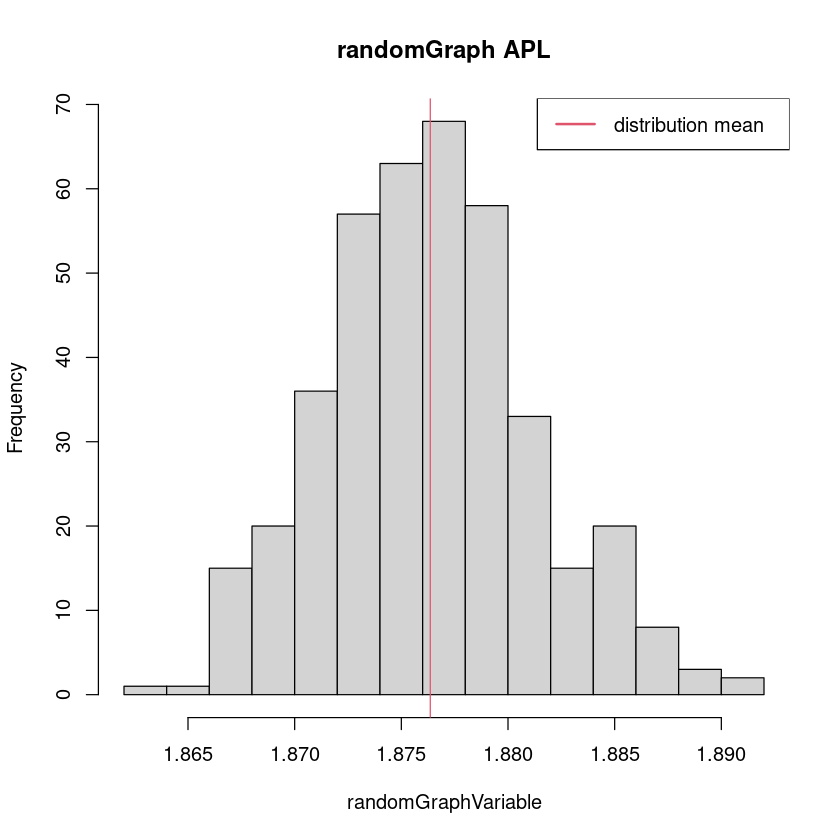

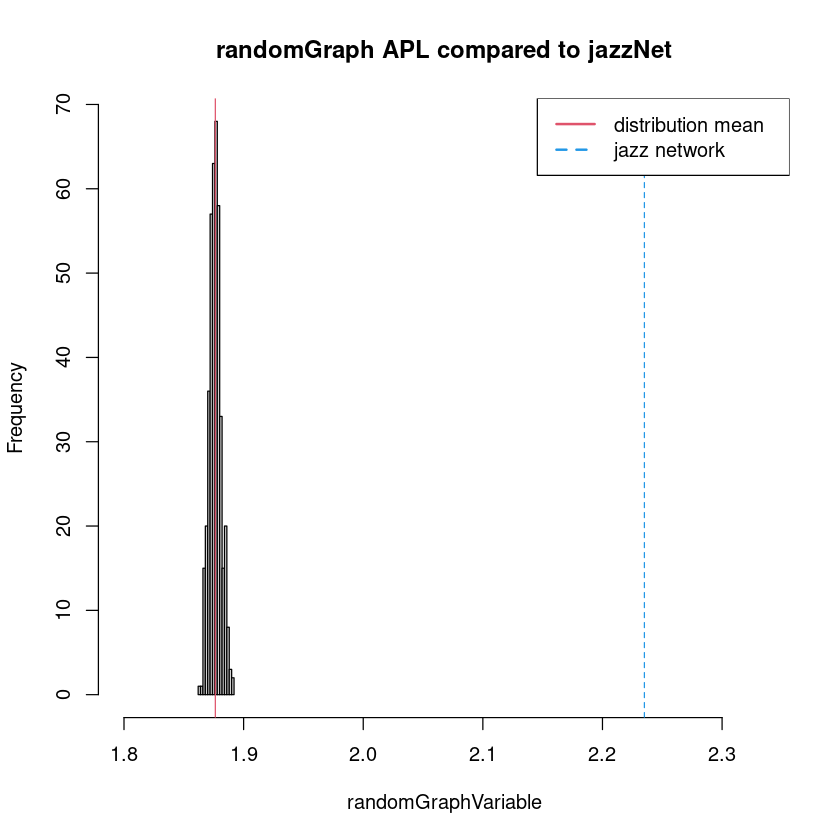

In [17]:
plotDistribution(randomGraphData$apl,
                 jazzNet_apl,
                 c(1.8, jazzNet_apl+0.1),
                 "randomGraph APL");

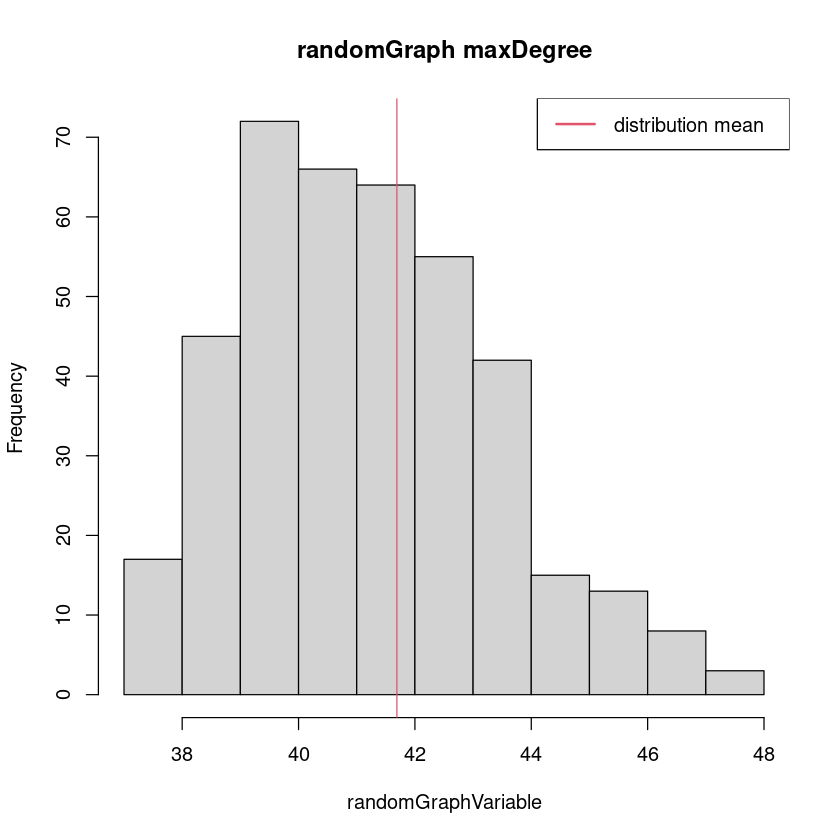

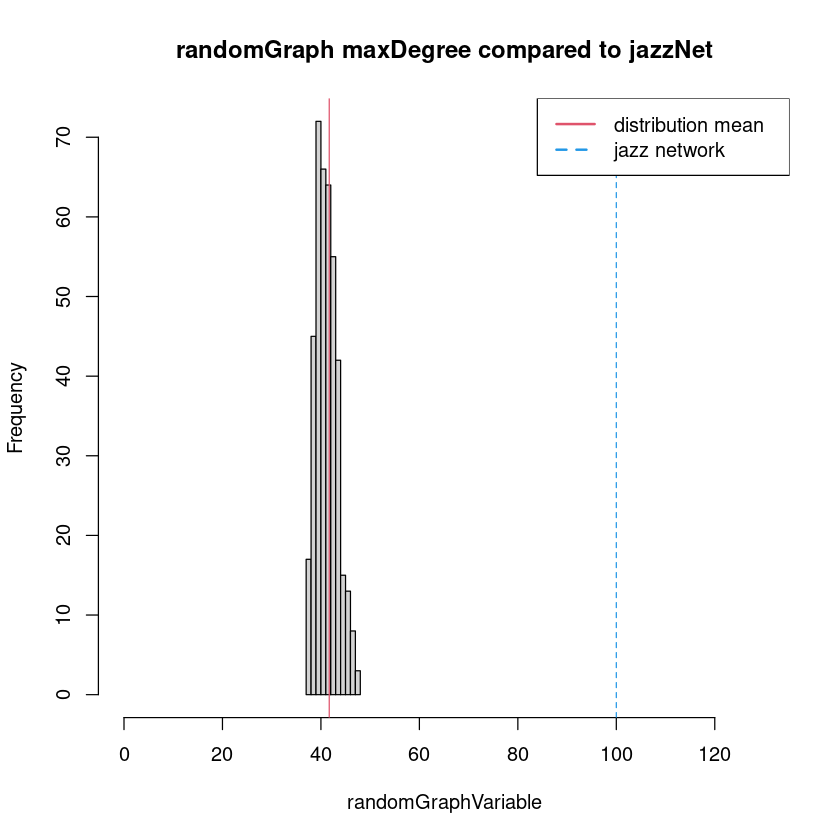

In [18]:
plotDistribution(randomGraphData$maxDegree,
                 jazzNet_maxDegree,
                 c(0, jazzNet_maxDegree+30),
                 "randomGraph maxDegree");

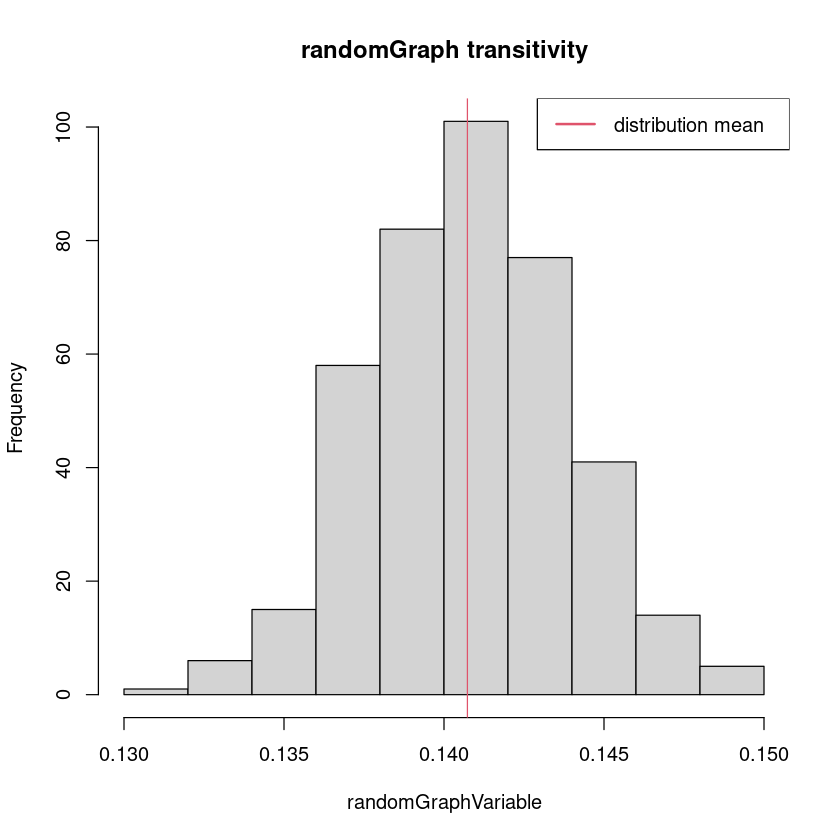

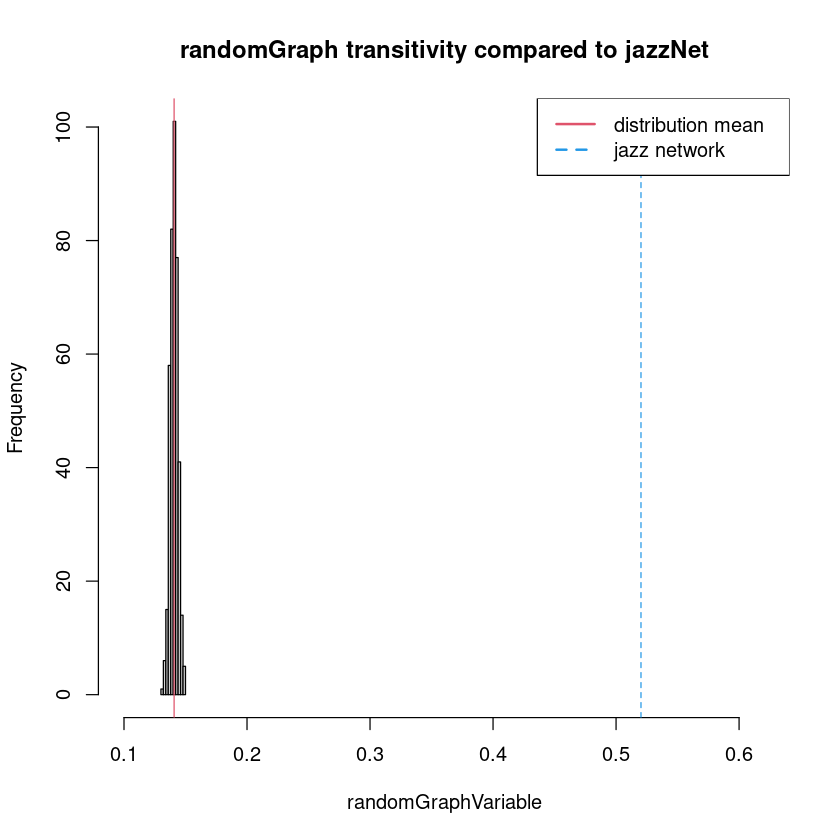

In [19]:
plotDistribution(randomGraphData$transitivity,
                 jazzNet_transitivity,
                 c(0.1, jazzNet_transitivity+0.1),
                 "randomGraph transitivity");

### Question 4

There are two extreme examples that generally do not descibe a real world network:

- Ring lattice:
    - High average path length
    - High clustering coefficient (transitivity)

- Random graph:
    - Low average path length
    - Low clustering coefficient (transitivity)
    
You would expect most real-world networks, like the `jazzNet`, to have these small-world characteristics:
- Low average path length
- High clustering coefficient (transitivity)

But in the charts previously `jazzNet` appears to have an average path length that is larger than the `randomGraph` average path length.

So, to see the `jazzNet` in context, let's generate a ring lattice with the same number of nodes and approximately same average degree as `jazzNet`.

.

In [20]:
connectOnRight = ceiling(jazzNet_meanDegree/2);

ringLattice = make_lattice(length = vCount,
                           dim = 1,
                           nei = connectOnRight,
                           circular = TRUE);

ringLattice_apl = igraph::average.path.length(ringLattice);
ringLattice_maxDegree = max(igraph::degree(ringLattice));
ringLattice_transitivity = igraph::transitivity(ringLattice);

# This will be close to, but slightly more than, jazzNet.
# Ceiling closer than floor
igraph::gsize(ringLattice)

[1] 2772

Now, we should see that the `jazzNet` is closer to the `ringLattice` in terms of the clustering coefficient, but closer to the mean of `randomGraph` in terms of average path length.

In the bar charts below, the red dotted line measures half the distance between the `ringLattice` and the mean for `randomGraph`

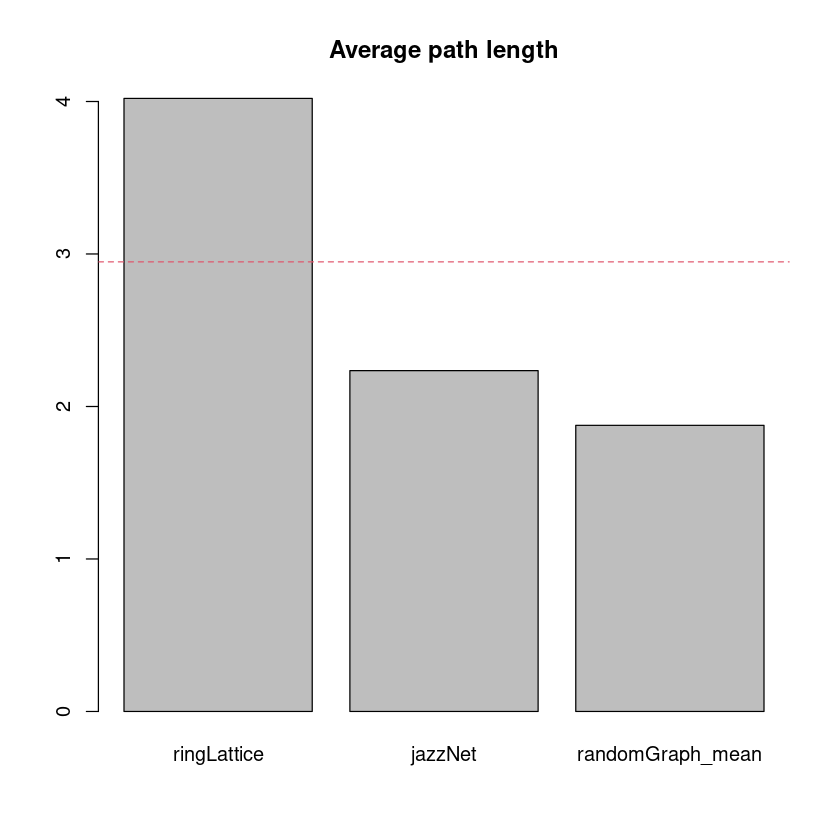

In [21]:
barplot(c(ringLattice_apl,
          jazzNet_apl,
          randomGraph_mean_apl),
        names = c("ringLattice", 
                  "jazzNet",
                  "randomGraph_mean"));

middle = mean(c(ringLattice_apl, randomGraph_mean_apl));
abline(h=middle, lty=2, col=2);
title("Average path length");

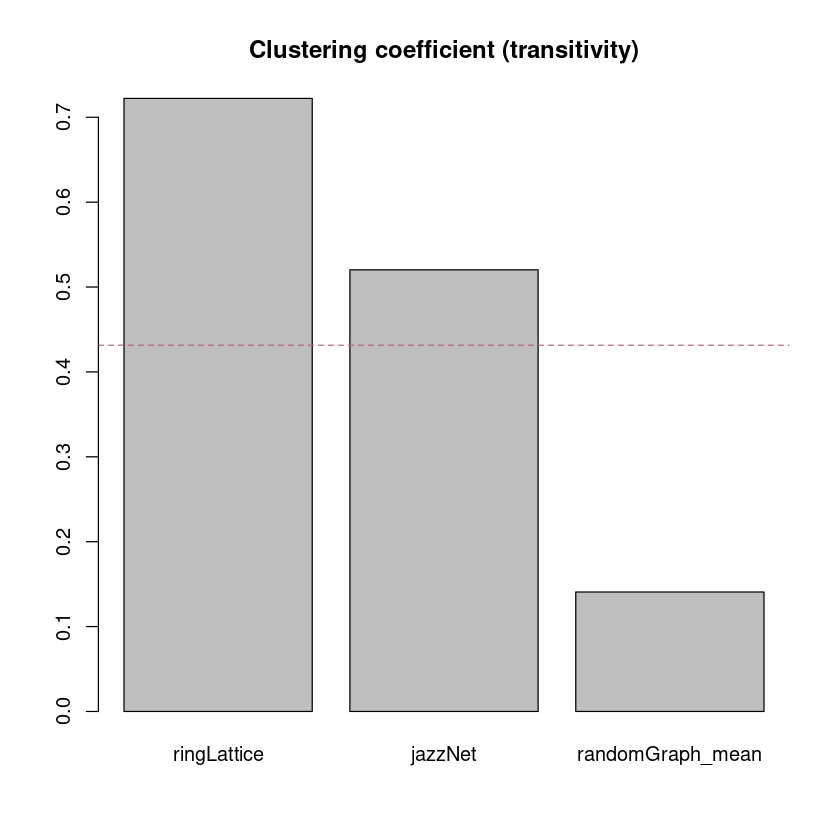

In [22]:
barplot(c(ringLattice_transitivity,
          jazzNet_transitivity,
          randomGraph_mean_transitivity),
        names = c("ringLattice", 
                  "jazzNet",
                  "randomGraph_mean"));

middle = mean(c(ringLattice_transitivity,
                randomGraph_mean_transitivity));
abline(h=middle, lty=2, col=2);

title("Clustering coefficient (transitivity)");

Then indeed, `jazzNet` exhibits the small-world properties that we expected to see.

### Appendix

Code, pasted here but not exectued

In [ ]:
# generateChart.R

# run this in Rstudio, it will be interactive

library('network', 'networkD3')

setwd("~/src/maths_notes/complex_networks/assignment2/")

jazz <- as.matrix(read.table("jazz_edgelist.txt"));

src <- jazz[,1] -1;
target <- jazz[,2] -1;
networkData <- data.frame(src, target);

# This generates an interactive plot. Best to run this as a script and then sa
networkD3::simpleNetwork(networkData, opacity = 0.5)


In [ ]:
# my_functions.R

getRandomGraphData = function(numberRandomGraphs, N, p) {
    randomGraphData <- data.frame();

    for (i in 1:numberRandomGraphs) {
        randomGraph <- igraph::sample_gnp(N, p); # ER model
        row = list(apl = igraph::average.path.length(randomGraph),
                   maxDegree = max(igraph::degree(randomGraph)),
                   transitivity = igraph::transitivity(randomGraph));

        randomGraphData = rbind(randomGraphData, row);
    }
    (randomGraphData)
}

plotDistribution = function(randomGraphVariable,
                            jazzNetStatistic,
                            xlims,
                            title) {

    randomGraphVariable_mean = mean(randomGraphVariable)

    hist(randomGraphVariable,
         main=title);
    abline(v=randomGraphVariable_mean, lty=1, col=2);
    legend(x = "topright",
        legend = c("distribution mean"),
        lty = c(1),
        col = c(2),
        lwd = 2);

    hist(randomGraphVariable,
         xlim = xlims,
         main=sprintf("%s compared to jazzNet", title));
    abline(v=randomGraphVariable_mean, lty=1, col=2);
    abline(v=jazzNetStatistic, lty=2, col=4);
    legend(x = "topright",
        legend = c("distribution mean", "jazz network"),
        lty = c(1, 2),
        col = c(2, 4),
        lwd = 2);
}
